In [7]:
%matplotlib widget
import numpy as np
import torch
from src.M_torch import M_torch
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [8]:
#Field parameters
Nc = 5 #Field revolutions in envelope
eps = 1 #(-1,0,1), Polarization of light
phi = 0 #Phase difference between envelope and field
#all values in au
wl = 0.057 #800nm wavelength
I = 0.003 #I=10^14 w/cm^2  
E0 = -0.500 #13.6 eV
res = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Uncomment this line to force CPU usage
M1 = M_torch(Nc, eps, phi, wl, I, E0, res, device=device)

Using device: cpu


In [9]:
# Define grid ranges and resolution
num_steps = 50
kxs = torch.linspace(-2, 2, steps=num_steps, device=device)
kys = torch.linspace(-2, 2, steps=num_steps, device=device)
kzs = torch.linspace(-2, 2, steps=num_steps, device=device)

# Create meshgrid
kxs_grid, kys_grid, kzs_grid = torch.meshgrid(kxs, kys, kzs, indexing='ij')

# Stack and reshape to (N, 3)
ks = torch.stack([kxs_grid, kys_grid, kzs_grid], dim=-1).reshape(-1, 3)


In [10]:
batch_size = 5000  # Adjust based on your GPU memory
Mk_squared_vals = []

for i in range(0, ks.shape[0], batch_size):
    ks_batch = ks[i:i+batch_size]
    Mk_batch = M1.Mk0_squared(ks_batch)
    Mk_squared_vals.append(Mk_batch.cpu())  # Move to CPU to free GPU memory

Mk_squared_vals = torch.cat(Mk_squared_vals)
Mk_squared_vals = Mk_squared_vals.reshape(kxs_grid.shape)
print('Mk_squared_vals reshaped:', Mk_squared_vals.shape)

Mk_squared_vals reshaped: torch.Size([50, 50, 50])


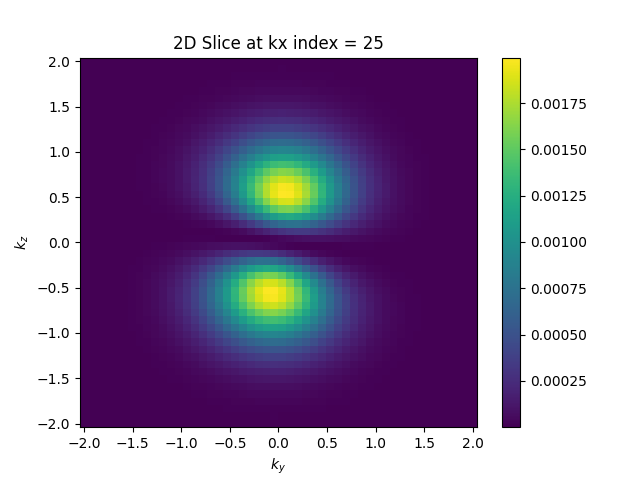

In [11]:
fig, ax = plt.subplots()

def plot_2d_slice(kx_val):
    ax.clear()
    # Create a 2D slice of the data
    slice_data = Mk_squared_vals[kx_val, :, :].cpu().numpy()
    kys_slice = kys_grid[kx_val, :, :].cpu().numpy()
    kzs_slice = kzs_grid[kx_val, :, :].cpu().numpy()

    # Plot the 2D slice
    c = ax.pcolormesh(kys_slice, kzs_slice, slice_data, shading='auto')
    ax.set_title(f'2D Slice at kx index = {kx_val}')

    ax.set_xlabel('$k_y$')
    ax.set_ylabel('$k_z$')
    fig.colorbar(c, ax=ax)
    # # Remove previous colorbars if any
    # if hasattr(plot_2d_slice, 'colorbar') and plot_2d_slice.colorbar:
    #     plot_2d_slice.colorbar.remove()
    # plot_2d_slice.colorbar = fig.colorbar(c, ax=ax)

# # Initialize colorbar attribute
# plot_2d_slice.colorbar = None


# Create a slider for kx
# kx_slider = widgets.IntSlider(value=num_steps/2, min=0, max=kxs_grid.shape[0]-1, step=1, description='kx index')
# out = widgets.interact_manual(plot_2d_slice, kx_val=kx_slider)

#Display the initial plot
plot_2d_slice(num_steps//2)
# display(out)


interactive(children=(FloatSlider(value=5e-05, continuous_update=False, description='Threshold', max=0.0024852…

<function __main__.update_plot(threshold)>

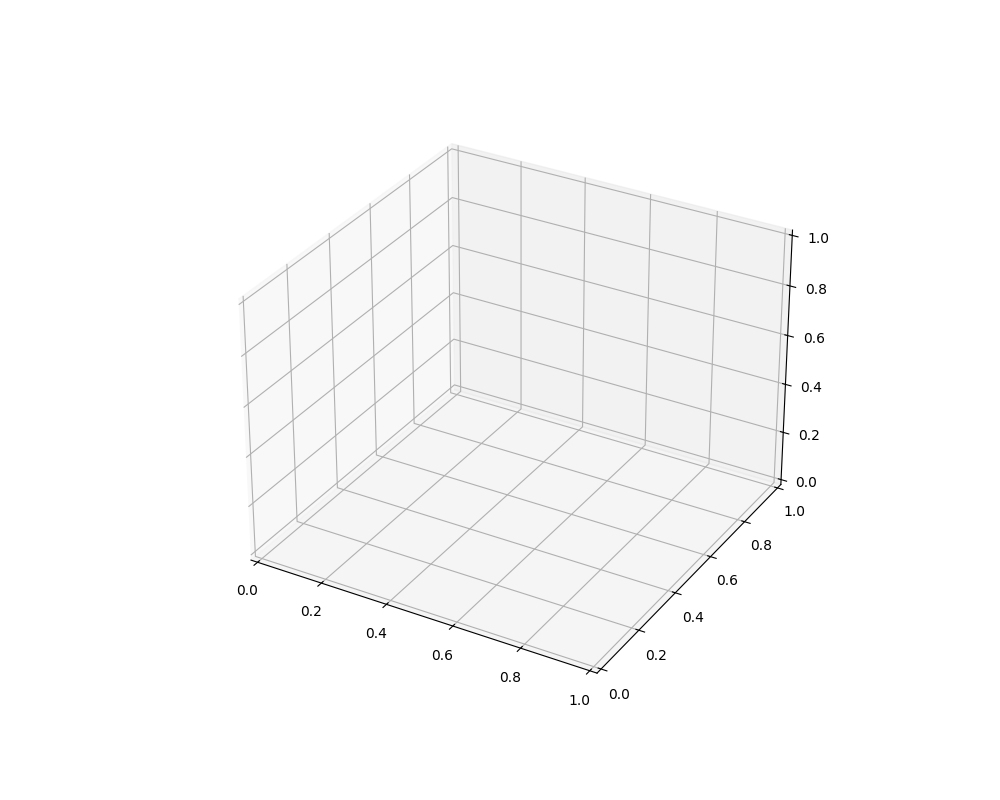

In [12]:
threshold = 0.00005 # or any value you want

# Flatten everything for easy masking
kxs_flat = kxs_grid.flatten()
kys_flat = kys_grid.flatten()
kzs_flat = kzs_grid.flatten()
Mk_flat = Mk_squared_vals.flatten()

mask_slider = widgets.FloatSlider(
    value=threshold,
    min=Mk_squared_vals.min().item(),
    max=Mk_squared_vals.max().item(),
    step=0.00001,
    description='Threshold',
    continuous_update=False,
    readout_format='.5f',
)
# Create mask for values above threshold

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def update_plot(threshold):
    ax.cla()  # Clear the previous plot
    mask = Mk_flat > threshold
    # Plot only the points above threshold
    sc = ax.scatter(
        kxs_flat[mask].cpu(), kys_flat[mask].cpu(), kzs_flat[mask].cpu(),
        c=Mk_flat[mask].cpu(), cmap='viridis', marker='o', alpha=0.3, s=10
    )
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title('3D plot of Mk_squared_vals (thresholded)')


out_3d = widgets.interact_manual(update_plot, threshold=mask_slider)

# Display the initial plot
display(out_3d)